# RNN Encoder

RNN model to encode an abstract and predict the gender of the study

In [81]:
%store -r abstracts_w2v_embeddings abstracts_targets_collapsed

In [85]:
abstracts_targets_collapsed.groupby('gender').size() / len(abstracts_targets_collapsed)

gender
Both      0.870043
Female    0.088868
Male      0.041089
dtype: float64

### Training Data

In [2]:
X_idxs = list(abstracts_targets_collapsed.abstracts_idxed)

ys = abstracts_targets_collapsed.gender

# Binarize ys
num_classes = len(ys.unique())
binarize = {i: label for i, label in zip(ys.unique(), range(num_classes))}
ys = ys.map(binarize)

### Hyperparameters

In [3]:
M, WORD_DIM = abstracts_w2v_embeddings.shape
H, C = 10, len(ys.unique())
learning_rate = .005

In [4]:
from rnn.cell import VanillaCell
from rnn.encoder import FixedVectorEncoder
from rnn.decoder import SoftmaxDecoder

cell = VanillaCell(H, WORD_DIM)
encoder, decoder = FixedVectorEncoder(cell), SoftmaxDecoder(H, num_classes)

In [39]:
from rnn.model import RNN

rnn = RNN(abstracts_w2v_embeddings, H, num_classes, encoder, decoder)

In [65]:
rnn.sgd_step(X_idxs[0], ys[0], learning_rate)

array(0.10856252293113375)

### Example

In [260]:
def training_example_generator():
    while True:
        for x_idxs, y in zip(X_idxs_[:10], ys[:10]):
            yield x_idxs, y

In [261]:
rnn = RNN()

def loss_generator(num_iters):
    example = training_example_generator()

    for i in range(num_iters):
        x_idxs, y = next(example)

        yield train(x_idxs, y, .005)

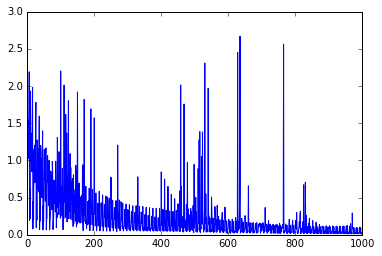

In [262]:
pd.Series([float(loss) for loss in list(loss_generator(1000))]).plot()